In [1]:
# Importing the necessary packages

import pandas as pd
import pandas_datareader as web
import numpy as np
import matplotlib.pyplot as plt

/Users/nevrocerasani/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Coding the strategy

def strategy(stock):
    
    #Retrieving the prices
    start_date = "01-01-2018"
    end_date = "08-01-2020"
    prices = web.DataReader(stock, data_source="yahoo", start=start_date, end=end_date)["Adj Close"].to_frame()
    df = pd.DataFrame()
    df[stock] = prices["Adj Close"]
    
    # Computing the moving averages
    periods = [7,14,21]
    terms = ["Short", "Medium", "Long"]
    for i in range(len(periods)):
        df["MA " + str(terms[i])] = df[stock].ewm(span=periods[i]).mean()
    
    duplicated = df[df.index.duplicated()]
    for i in duplicated.index:
        df.drop(i, axis=0, inplace=True)
    
    # Computing the RSI
    def RSI (df, time_window):
        diff = df.diff(1).dropna()
        up_chg = 0 * diff
        down_chg = 0 * diff
        up_chg[diff > 0] = diff[diff>0]
        down_chg[diff < 0] = diff[diff < 0]
        up_chg_avg = up_chg.ewm(com=time_window-1, min_periods=time_window).mean()
        down_chg_avg = down_chg.ewm(com=time_window-1, min_periods=time_window).mean()
        rs = abs(up_chg_avg/down_chg_avg)
        rsi = 100 - 100/(1+rs)
        return rsi
    df["RSI"] = RSI(df[stock], 14)
    df = df.dropna()
    
    # Determining the direction of the trend and its strenght
    df["Trend"] = ["Bullish" if k[stock]>k["MA Long"] else "Bearish" for j,k in df.iterrows()]
    df["Trend strenght"] = ["Strong" if i>50 else "Weak" for i in df["RSI"]]
    
    # Generating the signals
    signal = []
    flag = "N"
    for i in range(len(df)):
        if df["MA Short"][i]>df["MA Medium"][i] and flag!="B" and df["Trend"][i]=="Bullish" and df["Trend strenght"][i]=="Strong":
            signal.append("Buy")
            flag="B"
        elif df["MA Short"][i]<df["MA Medium"][i] and flag!="S" and df["Trend"][i]=="Bearish" and df["Trend strenght"][i]=="Weak":
            signal.append("Sell")
            flag="S"
        else:
            signal.append(np.nan)
    signal[0] = np.nan
    indices = [signal.index(i) for i in signal if (i=="Buy") | (i=="Sell")]
    signal[indices[0]] = np.nan
    df["Signal"] = signal
    
    buy_signals = []
    sell_signals = []
    for j,k in df.iterrows():
        if k["Signal"] == "Buy":
            buy_signals.append(k[stock])
            sell_signals.append(np.nan)
        elif k["Signal"] == "Sell":
            sell_signals.append(k[stock])
            buy_signals.append(np.nan)
        else:
            buy_signals.append(np.nan)
            sell_signals.append(np.nan)
        
    return df

In [3]:
# Selecting the stocks for the backtesting with a capital of 100000 €

shares = ["PYPL", "NFLX", "AAPL", "AMZN", "GOOGL", "FB"]
capital = 100000
portfolio = {}

dfs = []
for i in shares:
    dfs.append(strategy(i))

dates = dfs[3].index
port_trend = []

In [4]:
for i in dates:
    shares_in_port = portfolio.keys()
    allocation = capital/(len(shares) - len(portfolio))
    for j in dfs:
        which_share = j.columns[0]
        if j.loc[i,"Signal"]=="Buy":
            buy_price = j.loc[i, which_share]
            number_of_shares = np.floor(allocation/buy_price)
            portfolio[which_share] = [number_of_shares, buy_price]
            
        elif j.loc[i,"Signal"]=="Sell":
            if which_share in shares_in_port:
                profit = (j.loc[i, which_share] - portfolio[which_share][1]) * portfolio[which_share][0]
                capital += profit
                port_trend.append([i, capital])
                del portfolio[which_share]
        
        # Setting a stop loss of 10% below the buying price
        if (which_share in shares_in_port) and (j.loc[i, which_share] < portfolio[which_share][1]*0.9):
            profit = (j.loc[i, which_share] - portfolio[which_share][1]) * portfolio[which_share][0]
            capital += profit
            port_trend.append([i, capital])
            del portfolio[which_share]
        
        # Setting a stop profit of 20% above the buying price
        if (which_share in shares_in_port) and (j.loc[i, which_share] > portfolio[which_share][1]*1.2):
            profit = (j.loc[i, which_share] - portfolio[which_share][1]) * portfolio[which_share][0]
            capital += profit
            port_trend.append([i, capital])
            del portfolio[which_share]

/Users/nevrocerasani/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
print("If you had invested 100.000€ in 2018 according to this strategy, your capital now would be " + str(np.round(capital)) + "€.")
print("Plus, you would still have the following shares in your portfolio:")
for i in portfolio.keys():
    print(i)

If you had invested 100.000€ in 2018 according to this strategy, your capital now would be 243178.0€.
Plus, you would still have the following shares in your portfolio:
GOOGL
FB


In [6]:
port_df = pd.DataFrame()
port_df["Date"] = [i[0] for i in port_trend]
port_df["Capital"] = [i[1] for i in port_trend]
port_df["% Increase/Decrease"] = np.round(((port_df["Capital"] - port_df["Capital"].shift(1)) / port_df["Capital"].shift(1)), 4)*100
port_df["ROI %"] = np.round((port_df["Capital"] - 100000) / 100000, 4)*100
port_df.set_index("Date")

,Capital,% Increase/Decrease,ROI %
Date,,,
2018-03-01,99307.180176,NaN,-0.69
2018-03-01,97688.981934,-1.63,-2.31
2018-03-19,96217.180725,-1.51,-3.78
2018-03-20,95813.140930,-0.42,-4.19
2018-03-21,95647.493835,-0.17,-4.35
...,...,...,...
2020-05-20,219822.745525,8.57,119.82
2020-06-09,236978.342449,7.80,136.98
2020-06-12,235501.442120,-0.62,135.50


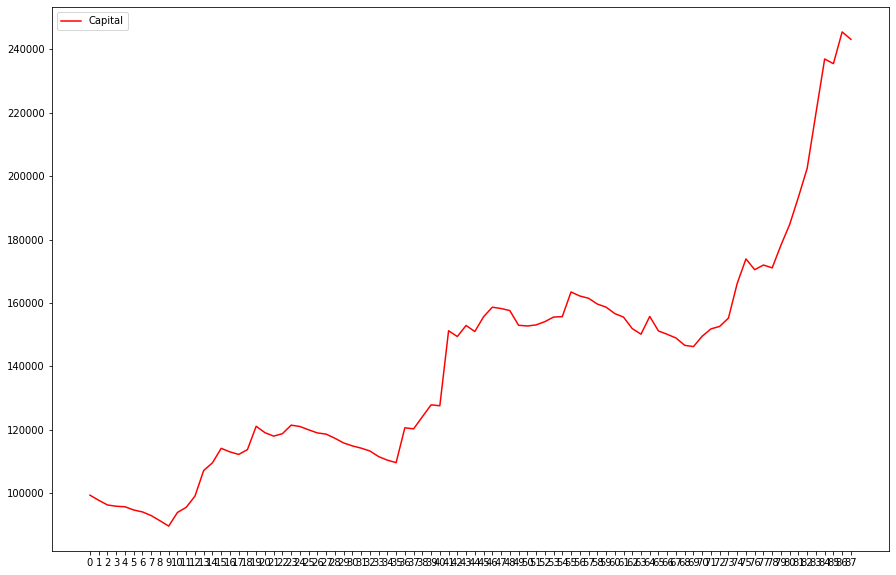

In [12]:
plt.figure(figsize=(15,10))
plt.plot(port_df["Capital"], label = "Capital", color="r")
plt.legend(loc="upper left")
plt.xticks(port_df.index)
plt.show()